<a href="https://colab.research.google.com/github/Park-YounHo/pytoch/blob/main/SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import urllib.request
import zipfile
import tarfile

In [7]:
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [8]:
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [9]:
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
target_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    tar = tarfile.TarFile(target_path)
    tar.extractall(data_dir)
    tar.close()

In [10]:
url = "https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth"
target_path = os.path.join(weights_dir, "vgg16_reducedfc.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

In [11]:
url = "https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth"
target_path = os.path.join(weights_dir, "ssd300_mAP_77.43_v2.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

In [12]:
import os.path as osp
import random
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline

In [13]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [14]:
def make_datapath_list(rootpath):
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')

    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')

    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()
        img_path = (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)

    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()
        img_path = (imgpath_template % file_id)
        anno_path = (annopath_template % file_id)
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list


In [15]:
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)

print(train_img_list[0])

./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg


In [16]:
class Anno_xml2list(object):

    def __init__(self, classes):

        self.classes = classes

    def __call__(self, xml_path, width, height):
        ret = []

        xml = ET.parse(xml_path).getroot()

        for obj in xml.iter('object'):

            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

            bndbox = []

            name = obj.find('name').text.lower().strip()
            bbox = obj.find('bndbox')

            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                cur_pixel = int(bbox.find(pt).text) - 1

                if pt == 'xmin' or pt == 'xmax':
                    cur_pixel /= width
                else:
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            ret += [bndbox]

        return np.array(ret)

In [17]:
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)
height, width, channels = img.shape

transform_anno(val_anno_list[ind], width, height)

array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

In [19]:
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans


class DataTransform():
    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(), 
                ToAbsoluteCoords(), 
                PhotometricDistort(), 
                Expand(color_mean), 
                RandomSampleCrop(),  
                RandomMirror(),  
                ToPercentCoords(),  
                Resize(input_size),  
                SubtractMeans(color_mean) 
            ]),
            'val': Compose([
                ConvertFromInts(),  
                Resize(input_size), 
                SubtractMeans(color_mean) 
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        return self.data_transform[phase](img, boxes, labels)

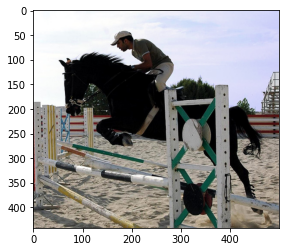

/content/utils/data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)


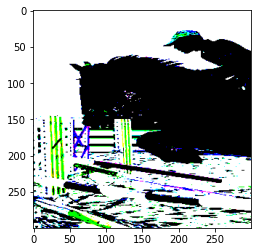

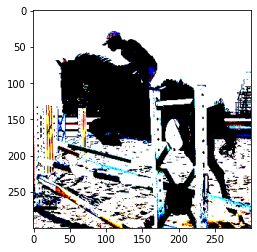

In [20]:
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)  
height, width, channels = img.shape  

transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

color_mean = (104, 117, 123) 
input_size = 300 
transform = DataTransform(input_size, color_mean)

phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

In [21]:
class VOCDataset(data.Dataset):

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase 
        self.transform = transform  
        self.transform_anno = transform_anno  

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path) 
        height, width, channels = img.shape 

        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])

        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width

In [22]:
color_mean = (104, 117, 123)
input_size = 300

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


val_dataset.__getitem__(1)

(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9083,  -13.2200,
             -9.4033],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9500,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2817,  -20.1750,   -5.5633,  ..., -104.9933, -111.8350,
           -119.0000],
          [ -20.4767,  -21.0000,  -12.6333,  ..., -107.1683, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0767,  -14.7250,
            -11.8533],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5017,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9500,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

In [23]:
def od_collate_fn(batch):

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0]) 
        targets.append(torch.FloatTensor(sample[1]))

    imgs = torch.stack(imgs, dim=0)

    return imgs, targets

In [24]:
batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

batch_iterator = iter(dataloaders_dict["val"]) 
images, targets = next(batch_iterator) 
print(images.size())
print(len(targets))
print(targets[1].size())

torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])


In [26]:
print(train_dataset.__len__())
print(val_dataset.__len__())

5717
5823


In [27]:
from math import sqrt
from itertools import product

import pandas as pd
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

In [28]:
def make_vgg():
    layers = []
    in_channels = 3 

    cfg = [64, 64, 'M', 128, 128, 'M', 256, 256,
           256, 'MC', 512, 512, 512, 'M', 512, 512, 512]

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)

vgg_test = make_vgg()
print(vgg_test)


ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_siz

In [29]:
def make_extras():
    layers = []
    in_channels = 1024 

    cfg = [256, 512, 128, 256, 128, 256, 128, 256]

    layers += [nn.Conv2d(in_channels, cfg[0], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[0], cfg[1], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[1], cfg[2], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[2], cfg[3], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[3], cfg[4], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[4], cfg[5], kernel_size=(3))]
    layers += [nn.Conv2d(cfg[5], cfg[6], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[6], cfg[7], kernel_size=(3))]

    return nn.ModuleList(layers)

extras_test = make_extras()
print(extras_test)


ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


In [30]:
def make_loc_conf(num_classes=21, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):

    loc_layers = []
    conf_layers = []

    loc_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                              * num_classes, kernel_size=3, padding=1)]

    loc_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                              * num_classes, kernel_size=3, padding=1)]

    loc_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                              * num_classes, kernel_size=3, padding=1)]

    loc_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                              * num_classes, kernel_size=3, padding=1)]

    loc_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                              * num_classes, kernel_size=3, padding=1)]

    loc_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                              * num_classes, kernel_size=3, padding=1)]

    return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)

loc_test, conf_test = make_loc_conf()
print(loc_test)
print(conf_test)


ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [31]:
class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale 
        self.reset_parameters() 
        self.eps = 1e-10

    def reset_parameters(self):
        init.constant_(self.weight, self.scale)

    def forward(self, x):
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt()+self.eps
        x = torch.div(x, norm)

        weights = self.weight.unsqueeze(
            0).unsqueeze(2).unsqueeze(3).expand_as(x)
        out = weights * x

        return out

In [32]:
class DBox(object):
    def __init__(self, cfg):
        super(DBox, self).__init__()

        self.image_size = cfg['input_size']
        self.feature_maps = cfg['feature_maps']
        self.num_priors = len(cfg["feature_maps"]) 
        self.steps = cfg['steps']
        
        self.min_sizes = cfg['min_sizes']
        
        self.max_sizes = cfg['max_sizes']
        
        self.aspect_ratios = cfg['aspect_ratios']

    def make_dbox_list(self):
        mean = []
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):
                f_k = self.image_size / self.steps[k]

                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k

                s_k = self.min_sizes[k]/self.image_size
                mean += [cx, cy, s_k, s_k]

                s_k_prime = sqrt(s_k * (self.max_sizes[k]/self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]

                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    mean += [cx, cy, s_k/sqrt(ar), s_k*sqrt(ar)]

        output = torch.Tensor(mean).view(-1, 4)

        output.clamp_(max=1, min=0)

        return output

In [33]:
ssd_cfg = {
    'num_classes': 21, 
    'input_size': 300,  
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4], 
    'feature_maps': [38, 19, 10, 5, 3, 1], 
    'steps': [8, 16, 32, 64, 100, 300], 
    'min_sizes': [30, 60, 111, 162, 213, 264], 
    'max_sizes': [60, 111, 162, 213, 264, 315],
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

pd.DataFrame(dbox_list.numpy())

,0,1,2,3
0,0.013333,0.013333,0.100000,0.100000
1,0.013333,0.013333,0.141421,0.141421
2,0.013333,0.013333,0.141421,0.070711
3,0.013333,0.013333,0.070711,0.141421
4,0.040000,0.013333,0.100000,0.100000
...,...,...,...,...
8727,0.833333,0.833333,0.502046,1.000000
8728,0.500000,0.500000,0.880000,0.880000
8729,0.500000,0.500000,0.961249,0.961249
8730,0.500000,0.500000,1.000000,0.622254


In [34]:
class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase
        self.num_classes = cfg["num_classes"] 

        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        if phase == 'inference':
            self.detect = Detect()

ssd_test = SSD(phase="train", cfg=ssd_cfg)
print(ssd_test)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [35]:
def decode(loc, dbox_list):
    boxes = torch.cat((
        dbox_list[:, :2] + loc[:, :2] * 0.1 * dbox_list[:, 2:],
        dbox_list[:, 2:] * torch.exp(loc[:, 2:] * 0.2)), dim=1)

    boxes[:, :2] -= boxes[:, 2:] / 2  
    boxes[:, 2:] += boxes[:, :2]

    return boxes

In [36]:
def nm_suppression(boxes, scores, overlap=0.45, top_k=200):
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)

    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()

    v, idx = scores.sort(0)

    idx = idx[-top_k:]

    while idx.numel() > 0:
        i = idx[-1] 

        keep[count] = i
        count += 1

        if idx.size(0) == 1:
            break

        idx = idx[:-1]

        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)

        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i])

        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)

        inter = tmp_w*tmp_h

        rem_areas = torch.index_select(area, 0, idx) 
        union = (rem_areas - inter) + area[i] 
        IoU = inter/union

        idx = idx[IoU.le(overlap)] 

    return keep, count

In [37]:
class Detect(Function):

    def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
        self.softmax = nn.Softmax(dim=-1)
        self.conf_thresh = conf_thresh 
        self.top_k = top_k 
        self.nms_thresh = nms_thresh 

    def forward(self, loc_data, conf_data, dbox_list):
        num_batch = loc_data.size(0) 
        num_dbox = loc_data.size(1)
        num_classes = conf_data.size(2)  

        conf_data = self.softmax(conf_data)

        output = torch.zeros(num_batch, num_classes, self.top_k, 5)

        conf_preds = conf_data.transpose(2, 1)

        for i in range(num_batch):

            decoded_boxes = decode(loc_data[i], dbox_list)

            conf_scores = conf_preds[i].clone()

            for cl in range(1, num_classes):

                c_mask = conf_scores[cl].gt(self.conf_thresh)

                scores = conf_scores[cl][c_mask]

                if scores.nelement() == 0: 
                    continue

                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)

                boxes = decoded_boxes[l_mask].view(-1, 4)

                ids, count = nm_suppression(
                    boxes, scores, self.nms_thresh, self.top_k)

                output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1),
                                                   boxes[ids[:count]]), 1)

        return output

In [38]:
class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase 
        self.num_classes = cfg["num_classes"]

        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        if phase == 'inference':
            self.detect = Detect()

    def forward(self, x):
        sources = list() 
        loc = list() 
        conf = list() 

        for k in range(23):
            x = self.vgg[k](x)

        source1 = self.L2Norm(x)
        sources.append(source1)

        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)

        sources.append(x)

        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1: 
                sources.append(x)

        for (x, l, c) in zip(sources, self.loc, self.conf):
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())

        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        output = (loc, conf, self.dbox_list)

        if self.phase == "inference": 
            return self.detect(output[0], output[1], output[2])

        else:  
            return output

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from utils.match import match

In [40]:
class MultiBoxLoss(nn.Module):

    def __init__(self, jaccard_thresh=0.5, neg_pos=3, device='cpu'):
        super(MultiBoxLoss, self).__init__()
        self.jaccard_thresh = jaccard_thresh  
        self.negpos_ratio = neg_pos  
        self.device = device 

    def forward(self, predictions, targets):
        loc_data, conf_data, dbox_list = predictions

        num_batch = loc_data.size(0) 
        num_dbox = loc_data.size(1) 
        num_classes = conf_data.size(2) 

        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)


        for idx in range(num_batch):

            truths = targets[idx][:, :-1].to(self.device) 
            labels = targets[idx][:, -1].to(self.device)

            dbox = dbox_list.to(self.device)

            variance = [0.1, 0.2]
            match(self.jaccard_thresh, truths, dbox,
                  variance, labels, loc_t, conf_t_label, idx)

        pos_mask = conf_t_label > 0 

        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)

        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')

        batch_conf = conf_data.view(-1, num_classes)

        loss_c = F.cross_entropy(
            batch_conf, conf_t_label.view(-1), reduction='none')

        num_pos = pos_mask.long().sum(1, keepdim=True)
        loss_c = loss_c.view(num_batch, -1)
        loss_c[pos_mask] = 0

        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)

        num_neg = torch.clamp(num_pos*self.negpos_ratio, max=num_dbox)

        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)

        conf_hnm = conf_data[(pos_idx_mask+neg_idx_mask).gt(0)
                             ].view(-1, num_classes)

        conf_t_label_hnm = conf_t_label[(pos_mask+neg_mask).gt(0)]

        loss_c = F.cross_entropy(conf_hnm, conf_t_label_hnm, reduction='sum')

        N = num_pos.sum()
        loss_l /= N
        loss_c /= N

        return loss_l, loss_c

In [41]:
import os.path as osp
import random
import time

import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data

In [42]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("사용 중인 장치：", device)

사용 중인 장치： cpu


In [44]:
from utils.ssd_model import make_datapath_list, VOCDataset, DataTransform, Anno_xml2list, od_collate_fn

rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath)

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']
color_mean = (104, 117, 123)
input_size = 300

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

batch_size = 32

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

In [45]:
from utils.ssd_model import SSD

ssd_cfg = {
    'num_classes': 21, 
    'input_size': 300,  
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4], 
    'feature_maps': [38, 19, 10, 5, 3, 1],  
    'steps': [8, 16, 32, 64, 100, 300], 
    'min_sizes': [30, 60, 111, 162, 213, 264], 
    'max_sizes': [60, 111, 162, 213, 264, 315], 
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

net = SSD(phase="train", cfg=ssd_cfg)

vgg_weights = torch.load('./weights/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None: 
            nn.init.constant_(m.bias, 0.0)

net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("사용 중인 장치：", device)

print('네트워크 설정 완료: 학습된 가중치를 로드했습니다')

사용 중인 장치： cpu
네트워크 설정 완료: 학습된 가중치를 로드했습니다


In [46]:
from utils.ssd_model import MultiBoxLoss

criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

optimizer = optim.SGD(net.parameters(), lr=1e-3,
                      momentum=0.9, weight_decay=5e-4)

In [47]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 중인 장치：", device)

    net.to(device)

    torch.backends.cudnn.benchmark = True

    iteration = 1
    epoch_train_loss = 0.0  
    epoch_val_loss = 0.0 
    logs = []

    for epoch in range(num_epochs+1):

        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  
                print('（train）')
            else:
                if((epoch+1) % 10 == 0):
                    net.eval()  
                    print('-------------')
                    print('（val）')
                else:
                    continue

            for images, targets in dataloaders_dict[phase]:

                images = images.to(device)
                targets = [ann.to(device)
                           for ann in targets] 

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(images)

                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c

                    if phase == 'train':
                        loss.backward()  

                        nn.utils.clip_grad_value_(
                            net.parameters(), clip_value=2.0)

                        optimizer.step()  

                        if (iteration % 10 == 0):  
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('반복 {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item(), duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()
                        iteration += 1

                    else:
                        epoch_val_loss += loss.item()

        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss, epoch_val_loss))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        log_epoch = {'epoch': epoch+1,
                     'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")

        epoch_train_loss = 0.0  
        epoch_val_loss = 0.0 

        if ((epoch+1) % 10 == 0):
            torch.save(net.state_dict(), 'weights/ssd300_' +
                       str(epoch+1) + '.pth')

In [49]:
num_epochs= 50  
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

사용 중인 장치： cpu
-------------
Epoch 1/50
-------------
（train）


KeyboardInterrupt: ignored

In [50]:
import cv2 
import matplotlib.pyplot as plt 
import numpy as np
import torch

%matplotlib inline

In [51]:
from utils.ssd_model import SSD

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

ssd_cfg = {
    'num_classes': 21,  
    'input_size': 300, 
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4], 
    'feature_maps': [38, 19, 10, 5, 3, 1],  
    'steps': [8, 16, 32, 64, 100, 300],  
    'min_sizes': [30, 60, 111, 162, 213, 264], 
    'max_sizes': [60, 111, 162, 213, 264, 315], 
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

net = SSD(phase="inference", cfg=ssd_cfg)

net_weights = torch.load('./weights/ssd300_50.pth',
                         map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

print('네트워크 설정 완료: 학습된 가중치를 로드했습니다')


네트워크 설정 완료: 학습된 가중치를 로드했습니다


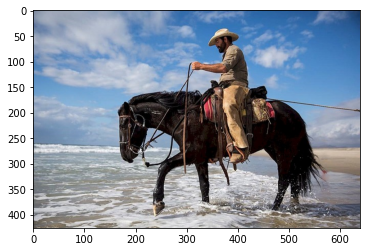

RuntimeError: ignored

In [57]:
from utils.ssd_model import DataTransform

image_file_path = "./data/cowboy-757575_640.jpg"
img = cv2.imread(image_file_path)  
height, width, channels = img.shape  

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

color_mean = (104, 117, 123) 
input_size = 300 
transform = DataTransform(input_size, color_mean)

phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, "", "")
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

net.eval()  
x = img.unsqueeze(0)  
detections = net(x)

print(detections.shape)
print(detections)

In [55]:
from utils.ssd_predict_show import SSDPredictShow

image_file_path = "./data/cowboy-757575_640.jpg"

ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.6)

RuntimeError: ignored